In [1]:
from pystac_client import Client as stac_client
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import xarray as xr
import numpy as np

from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

import rasterio
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio.vrt import WarpedVRT


from cv2 import dilate
from shapely import bounds
from shapely.geometry import box, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import datetime

import glob
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

In [2]:
def intersects(item_bbox, poly):
    return shapely.box(*item_bbox).intersects(poly)


def scale_to_reflectance(dn):
    return dn.astype('float32') * 1e-4


def scale_to_8bit(dn):
    return (((dn + 1) / 2) * 255).astype('int8')


def normalized_difference(x, y):
    denominator = x + y
    normalized_diff = (x - y) / np.where(denominator != 0, denominator, np.nan)

    return normalized_diff

In [3]:
mode = 'all'

In [4]:

if mode == 'all':
    square_path =(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\squares_15x_20251010.shp")
    # pill_path =(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\squares_15x_20251010.shp")
    circle_path =(r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\circles_3x_20251010.shp")
    pt_path = (r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\points_20251010.shp")


centerline_path = (r"C:\Users\dego\Documents\local_files\RSSA\Platte_centerlines_masks\Vector_centerlines\s2_platte_centerlines.shp")


def _init_worker(square_path, circle_path, centerline_path, href_dict_in):
    global squares, circles, vector_centerline, HREFS

    squares = gpd.read_file(square_path).set_crs(4326)
    circles = gpd.read_file(circle_path).set_crs(4326)
    pts = gpd.read_file(pt_path).set_crs(4326)
    vector_centerline = gpd.read_file(centerline_path).set_crs(4326, allow_override=True)

    duplicated_iidxes = circles.iindex[circles.iindex.duplicated()]
    circles = circles.loc[~circles.iindex.isin(duplicated_iidxes)]

    pairs = circles.sjoin(circles, how='inner', predicate='intersects')
    pairs = pairs[pairs.iindex_left != pairs.iindex_right].drop_duplicates()

    G = nx.from_pandas_edgelist(pairs, source='iindex_left', target='iindex_right')
    G.add_nodes_from(circles['iindex'])

    comp_map = {n:i for i, comp in enumerate(nx.connected_components(G)) for n in comp}
    circles['cluster'] = circles.iindex.map(comp_map)

    keep_idx = circles.groupby('cluster').sample(1, random_state=0).index
    circles = circles.loc[keep_idx].drop(columns='cluster')
    # circles = circles.loc[circles.iindex.isin(valid_iids)]

    squares = squares.loc[squares.iindex.isin(keep_idx)]
    pts = pts.loc[pts.iindex.isin(keep_idx)]

    HREFS = href_dict_in

In [415]:
stac = stac_client.open('https://earth-search.aws.element84.com/v1')

gage_search = stac.search(
    collections=['sentinel-2-l2a'],
    bbox=circles.total_bounds.tolist(),
    datetime='2018-01-01/2024-12-31',
    query={'eo:cloud_cover': {'lt': 20}},
    fields={'include': ['id', 'assets.B03', 'assets.B08', 'assets.SCL', 'bbox', 'properties.datetime']}
)
items = list(gage_search.items())

work = []
for item in tqdm(items):
    ibox = item.bbox
    b3_href = item.assets['green'].href
    b8_href = item.assets['nir'].href
    scl_href = item.assets['scl'].href

    for idx, row in circles.iterrows():
        if intersects(ibox, row[2]):
            work.append((item, row[0], b3_href, b8_href, scl_href))

id_hrefs = pd.DataFrame(work, columns=['img', 'iindex', 'b3_href', 'b8_href', 'scl_href'])

id_hrefs['img_id'] = id_hrefs.apply(lambda x: str(x['img']).split('=')[1][0:24], axis=1)
id_hrefs['mgrs'] = id_hrefs.apply(lambda x: x['img_id'].split('_')[1], axis=1)
id_hrefs['date'] = id_hrefs.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
id_hrefs['version'] = id_hrefs.apply(lambda x: x['img_id'].split('_')[3], axis=1)

# find duplicate images with different processing levels

tile_dts = []
tile_dt_versions = []
for row in tqdm(id_hrefs.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))


tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version'])\
    .sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = temp_df.head(1)
    nonduplicates.append(df_out)

nonduplicates = pd.concat(nonduplicates)



nonduplicate_id_hrefs = pd.merge(id_hrefs, nonduplicates[['mgrs', 'date', 'version']], how='right', on=['mgrs', 'date', 'version'])
nonduplicate_id_hrefs['year'] = nonduplicate_id_hrefs.apply(lambda x: x['date'].year, axis=1)
nonduplicate_id_hrefs['month'] = nonduplicate_id_hrefs.apply(lambda x: x['date'].month, axis=1)

nonduplicate_id_hrefs = nonduplicate_id_hrefs.set_index(['img_id', 'iindex'])

# # if mode == 'all':
# #     nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/all_sites/nonduplicate_stac_ids_hrefs_20250928.csv')
# # elif mode == 'extra_gages':
# #     nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_extra.csv')
# # elif mode == 'gage':
# #     nonduplicate_id_hrefs.to_csv('/content/drive/MyDrive/river_tinder_assets/gage_sites/nonduplicate_gage_stac_ids_20250921.csv')
nonduplicate_id_hrefs.to_csv(r"C:\Users\dego\Documents\local_files\RSSA\stac_img_ids_20251012.csv")

  0%|          | 0/36520 [00:00<?, ?it/s]C:\Users\dego\AppData\Local\Temp\ipykernel_43420\1972190642.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if intersects(ibox, row[2]):
  0%|          | 1/36520 [00:00<1:05:50,  9.24it/s]C:\Users\dego\AppData\Local\Temp\ipykernel_43420\1972190642.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  work.append((item, row[0], b3_href, b8_href, scl_href))
100%|██████████| 36520/36520 [1:06:36<00:00,  9.14it/s]
1208355it [00:38, 31200.46it/s]
100%|██████████| 13503/13503 [00:49<00:00, 271.36it/s]


In [6]:
nonduplicate_id_hrefs = pd.read_csv(r"C:\Users\dego\Documents\local_files\RSSA\stac_img_ids_20251012.csv")

In [1]:
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    tdf = nonduplicate_id_hrefs.loc[nonduplicate_id_hrefs.year == year]
    tdf.to_csv(f"C:/Users/dego/Documents/local_files/RSSA/stac_img_ids_{year}_20251012.csv")

NameError: name 'nonduplicate_id_hrefs' is not defined

In [18]:




def ref_geoms_from_b3href(b3_href, poly_idx, view_geoms, effwidth_geoms, centerline_geoms):
    with rasterio.open(b3_href) as src:
        img_crs = src.crs
    # print(poly_idx)
    view_geom = view_geoms.set_index('iindex').loc[poly_idx].geometry
    eff_geom = effwidth_geoms.set_index('iindex').loc[poly_idx].geometry

    t_view = Transformer.from_crs(view_geoms.crs, img_crs,  always_xy=True).transform
    t_eff = Transformer.from_crs(effwidth_geoms.crs, img_crs, always_xy=True).transform

    view_src = shp_transform(t_view, view_geom)
    eff_src  = shp_transform(t_eff,  eff_geom)

    # Filter lines by intersection in image CRS, then reproject only those (cheap)
    if centerline_geoms.crs != img_crs:
        cl_img = centerline_geoms.to_crs(img_crs)
    else:
        cl_img = centerline_geoms
    hits = list(cl_img.sindex.query(eff_src, predicate="intersects"))
    lines_in_bound = cl_img.iloc[hits].copy()

    return view_src, eff_src, lines_in_bound


def dn_to_reflectance(band):
    return np.float32(band) * 1e-4


def normalized_difference(b1, b2):
    denominator = b1 + b2
    numerator = b1 - b2
    return numerator / np.where(denominator != 0, denominator, np.nan)




def process_image_from_hrefs(b3_href, b8_href, scl_href, view_geom, otsu_geom):
    l, b, r, t = map(float, view_geom.bounds)

    with rasterio.open(b3_href) as b3_src:
        window = rasterio.windows.from_bounds(l, b, r, t, b3_src.transform).round_offsets().round_lengths()
        transform = b3_src.window_transform(window)

        h, w = window.height, window.width

        if h == 0 or w == 0:
            return np.array([1]), None, None, None, None, None

        b3v = b3_src.read(1, window=window, masked=True)
        b3_crs = b3_src.crs

    with rasterio.open(b8_href) as b8_src:
        b8v = b8_src.read(1, window=window, masked=True)

    with rasterio.open(scl_href) as scl_src, WarpedVRT(
        scl_src, crs=b3_crs, transform=transform, width=w, height=h, resampling=Resampling.nearest
    ) as vrt:
        sclv = vrt.read(1)

    b3v = dn_to_reflectance(b3v)
    b8v = dn_to_reflectance(b8v)
    ndwi_v = normalized_difference(b3v, b8v)
    otsu_geom_mask = geometry_mask([otsu_geom], out_shape=(h, w), transform=transform, invert=True)
    # return otsu_geom_mask, ndwi_v
    if otsu_geom_mask.size <= ndwi_v.size:
        ndwi_o = np.ma.array(ndwi_v, mask=~otsu_geom_mask).compressed()
        b8o = np.ma.array(b8v, mask=~otsu_geom_mask).compressed()

        if ndwi_o.size >= 10:
            ndwi_threshold = threshold_otsu(ndwi_o)
            nir_threshold = threshold_otsu(b8o)
        else:
            ndwi_threshold = 1
            nir_threshold = 1

        wmask = (ndwi_v >= ndwi_threshold) & (b8v <= nir_threshold)

        cloudmask = np.isin(sclv, [7, 8, 9]).astype('uint8')
        snowmask = (sclv == 11).astype('uint8')
        ndmask = (sclv != 0).astype('uint8')

        return ndwi_v, wmask, cloudmask, snowmask, ndmask, transform
    else:
        return np.array([1]), None, None, None, None, None





def identify_river(wmask, lines, window_trans):
    h, w = wmask.shape
    wbool = wmask.filled(0) > 0
    # rbuffs = lines.copy().buffer(5)
    shapes = ((geom, 1) for geom in lines.geometry)
    river_seed = rasterize(
        shapes=shapes,
        out_shape= (h, w),
        transform=window_trans,
        fill=0,
        dtype='uint8',
        all_touched=True
    )
    structure = np.ones((3, 3), dtype=bool)
    river_mask = ndi.binary_propagation(input=river_seed * wbool, mask=wbool, structure=structure)
    return river_mask


def GENERATE_MASKS(img_id, poly_idx, squares, circles, vector_centerlines, HREFS):
    b3_href, b8_href, scl_href = HREFS[(img_id, poly_idx)]

    circle_geom, lines = ref_geoms_from_b3href(b3_href, poly_idx, circles, vector_centerlines)

    ndwi_v, wmask, cloudmask, snowmask, ndmask, wwindow_transform = process_image_from_hrefs(b3_href, b8_href, scl_href, circle_geom)

    if ndwi_v.size > 1:

        rmask = identify_river(wmask, lines, wwindow_transform)

        return ndwi_v, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_geom
    else:
        return np.array([1]), None, None, None, None, None, None


def count_pixels(rmask, cloudmask, snowmask, ndmask, transform, circle):
    if rmask is not None:
        circle_mask = rasterize([circle], out_shape = rmask.shape, transform=transform, dtype='uint8', all_touched=True) == 1

        kernel = np.array([[0, 1, 0],
                        [1, 1, 1],
                        [0, 1, 0]]).astype('uint8')

        ring_mask = dilate(circle_mask.astype('uint8'), kernel, iterations=1) & ~circle_mask

        r = rmask.astype(bool)
        c = cloudmask.astype(bool)
        s = snowmask.astype(bool)
        v = ndmask.astype(bool)

        n_pixels = np.count_nonzero(circle_mask)
        n_valid = np.count_nonzero(circle_mask & v)
        n_river = np.count_nonzero(circle_mask & r)
        n_cloud = np.count_nonzero(circle_mask & c)
        n_snow = np.count_nonzero(circle_mask & s)
        n_cloudriver = np.count_nonzero(circle_mask & r & c)

        n_edge = np.count_nonzero(ring_mask)
        n_edgeriver = np.count_nonzero(ring_mask & r)

        return n_pixels, n_valid, n_river, n_cloud, n_snow, n_cloudriver, n_edge, n_edgeriver

    else:
        return -999, -999, -999, -999, -999, -999, -999, -999

In [8]:
nonduplicate_id_hrefs.reset_index().loc[(nonduplicate_id_hrefs.img_id == tid) & (nonduplicate_id_hrefs.iindex == tindx)]['b3_href'][1]

NameError: name 'tid' is not defined

In [ ]:
def show_plot(img_id, poly_idx, squares, circles, vector_centerlines):

    b3 = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.img_id == img_id) & (nonduplicate_id_hrefs.iindex == poly_idx)].reset_index()['b3_href'][0]
    b8 = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.img_id == img_id) & (nonduplicate_id_hrefs.iindex == poly_idx)].reset_index()['b8_href'][0]
    scl = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.img_id == img_id) & (nonduplicate_id_hrefs.iindex == poly_idx)].reset_index()['scl_href'][0]

    square, circle, lines = ref_geoms_from_b3href(b3, poly_idx, squares, circles, vector_centerlines)
    ndwi, wmask, cloud, snow, valid, transform = process_image_from_hrefs(b3, b8, scl, square, circle)


    rmask = identify_river(wmask, lines, transform)
    rm_cdict = {
            'red':   [[0.0, 0.0, 0.0],
                      [1.0, 1.0, 1.0]],
            'green': [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'blue':  [[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0]],
            'alpha': [[0.0, 0.0, 0.0],
                      [1.0, 0.35, 1.0]]
        }
    rm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=rm_cdict)

    cm_cdict = {
        'red':      [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'green':    [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'blue':     [[0.0, 0.0, 0.0],
                     [1.0, 1.0, 0.0]],
        'alpha':    [[0.0, 0.0, 0.0],
                     [1.0, 0.2, 1.0]]
    }
    cm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=cm_cdict)

    sm_cdict = {
        'red':      [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'green':    [[0.0, 0.0, 0.0],
                     [1.0, 1.0, 0.0]],
        'blue':     [[0.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0]],
        'alpha':    [[0.0, 0.0, 0.0],
                     [1.0, 0.2, 1.0]]
    }
    sm_cmap = LinearSegmentedColormap('custom_cmap', segmentdata=sm_cdict)

    if ndwi.size > 1:
        fig, (ax) = plt.subplots(ncols=1, nrows=1)
        show(ndwi, cmap='Greys_r', ax=ax, transform=transform)
        show(rmask, cmap=rm_cmap, ax=ax, transform=transform)
        show(cloud, cmap=cm_cmap, ax=ax, transform=transform)
        show(snow, cmap=sm_cmap, ax=ax, transform=transform)
        # show(ndmask, cmap=sm_cmap, ax=ax1, transform=transform)
        gpd.GeoSeries([circle]).plot(ax=ax, facecolor='none', edgecolor='tab:blue')
        (lines).plot(ax=ax)

    else:
        print('not enough in window')
    # tfig = plt.Figure()
    # ax_ndwi = tfig.add_subplot(1, 2, 1)
    # show(ndwi, cmap='Greys_r', ax=ax_ndwi)
    # ax_scl = tfig.add_subplot(1, 2, 2)
    # show(ndmask, cmap='Paired', ax=ax_scl)
    # tfig.suptitle(f'{img_id}_{poly_idx}')
    # tfig.tight_layout()

    # return fig

In [11]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year_imgs = {}
month_imgs = {}



href_dict = {(row.img_id, int(row.iindex)): (row.b3_href, row.b8_href, row.scl_href)
    for _, row in nonduplicate_id_hrefs.reset_index().iterrows()}

_init_worker(square_path, circle_path, centerline_path, href_dict)


def _worker(args):
    img_id, idx = args
    # return idx
    try:
        ndwi, rmask, cloudmask, snowmask, ndmask, trans, circle_poly = GENERATE_MASKS(
            img_id, idx, squares, circles, vector_centerline
        )
        if ndwi.size < 1:
            return(img_id, idx, -999, -999, -999, -999, -999, -999, -999, -999)

        return(img_id, idx, *count_pixels(rmask, cloudmask, snowmask, ndmask, trans, circle_poly))

    except Exception:
        return(img_id, idx, -999, -999, -999, -999, -999, -999, -999, -999)


paths = (square_path, circle_path, centerline_path)



NameError: name 'nx' is not defined

In [22]:
import networkx as nx

In [210]:
for y in years:
    month_imgs = {}
    for m in months:
        month_imgs[m] = nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.month == m) & (nonduplicate_id_hrefs.year == y)]
            # .set_index(['img_id', 'iindex'])
        # print(month_imgs[m].head())
    year_imgs[y] = month_imgs

In [231]:
year_imgs[2024][12].index.tolist()

[('S2A_14TPM_20241229_0_L2A', 1109),
 ('S2A_14TPM_20241229_0_L2A', 975),
 ('S2A_14TPM_20241229_0_L2A', 2138),
 ('S2A_14TPM_20241229_0_L2A', 2121),
 ('S2A_14TPM_20241229_0_L2A', 1995),
 ('S2A_14TPM_20241229_0_L2A', 2129),
 ('S2A_14TPM_20241229_0_L2A', 1232),
 ('S2A_14TPM_20241229_0_L2A', 1374),
 ('S2A_14TPM_20241229_0_L2A', 1450),
 ('S2A_14TPM_20241229_0_L2A', 1485),
 ('S2A_14TPM_20241229_0_L2A', 1536),
 ('S2A_14TPM_20241229_0_L2A', 1602),
 ('S2A_14TPM_20241229_0_L2A', 2060),
 ('S2A_14TPM_20241229_0_L2A', 2076),
 ('S2A_14TPM_20241229_0_L2A', 1772),
 ('S2A_14TPM_20241229_0_L2A', 1996),
 ('S2A_14TPM_20241229_0_L2A', 1986),
 ('S2A_14TPM_20241229_0_L2A', 2120),
 ('S2A_14TPM_20241229_0_L2A', 2047),
 ('S2A_14TPM_20241229_0_L2A', 808),
 ('S2A_14TPM_20241229_0_L2A', 811),
 ('S2A_14TPM_20241229_0_L2A', 844),
 ('S2A_14TPM_20241229_0_L2A', 859),
 ('S2A_14TPM_20241229_0_L2A', 861),
 ('S2A_14TPM_20241229_0_L2A', 891),
 ('S2A_14TPM_20241229_0_L2A', 894),
 ('S2A_14TPM_20241229_0_L2A', 897),
 ('S2A_14T

In [229]:


with ProcessPoolExecutor(max_workers=min(4, mp.cpu_count()), initializer=_init_worker, initargs=(paths[0], paths[1], paths[2], href_dict)) as ex:
    # for y in years:
    #     for m in months:
            # path_out = (f'/content/drive/MyDrive/effwidth_results/all_sites/effwidths_{m}_{y}_20250928.csv')
            # if path_out not in glob.glob(os.path.join('/content/drive/MyDrive/effwidth_results/all_sites/effwidths_*.csv')):

    tempdf = year_imgs[y][m]
    recs = tempdf.index.tolist()

    rows = list(tqdm(ex.map(_worker, recs, chunksize=8), total=len(recs), desc=f'{y}_{m}'))
    output = pd.DataFrame(rows, columns=['img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river', 'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver'])
    # output.to_csv(path_out)

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [225]:
list(tqdm(ex.map(_worker, recs, chunksize=8), total=len(recs), desc=f'{y}_{m}'))

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [227]:
mp.set_start_method("fork", force=True)

ValueError: cannot find context for 'fork'

In [ ]:
_init

NameError: name 'circles' is not defined

In [16]:
_init_worker(square_path, circle_path, centerline_path, href_dict, circles.iindex)

NameError: name 'circles' is not defined

In [13]:
nonduplicate_id_hrefs

,img_id,iindex,img,b3_href,b8_href,scl_href,mgrs,date,version,year,month
0,S2B_15TTF_20190806_1_L2A,154444,<Item id=S2B_15TTF_20190806_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,15TTF,2019-08-06,1,2019,8
1,S2B_15TTF_20190806_1_L2A,256673,<Item id=S2B_15TTF_20190806_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,15TTF,2019-08-06,1,2019,8
2,S2B_15TTF_20190806_1_L2A,204713,<Item id=S2B_15TTF_20190806_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,15TTF,2019-08-06,1,2019,8
3,S2B_15TTF_20190806_1_L2A,187680,<Item id=S2B_15TTF_20190806_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,15TTF,2019-08-06,1,2019,8
4,S2B_15TTF_20190806_1_L2A,154015,<Item id=S2B_15TTF_20190806_1_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,15TTF,2019-08-06,1,2019,8
...,...,...,...,...,...,...,...,...,...,...,...
865207,S2A_13TDG_20210531_0_L2A,65541,<Item id=S2A_13TDG_20210531_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TDG,2021-05-31,0,2021,5
865208,S2A_13TDG_20210531_0_L2A,64535,<Item id=S2A_13TDG_20210531_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TDG,2021-05-31,0,2021,5
865209,S2A_13TDG_20210531_0_L2A,65158,<Item id=S2A_13TDG_20210531_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TDG,2021-05-31,0,2021,5
865210,S2A_13TDG_20210531_0_L2A,64988,<Item id=S2A_13TDG_20210531_0_L2A>,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,https://sentinel-cogs.s3.us-west-2.amazonaws.c...,13TDG,2021-05-31,0,2021,5


S2B_14TML_20240908_0_L2A ,  222016


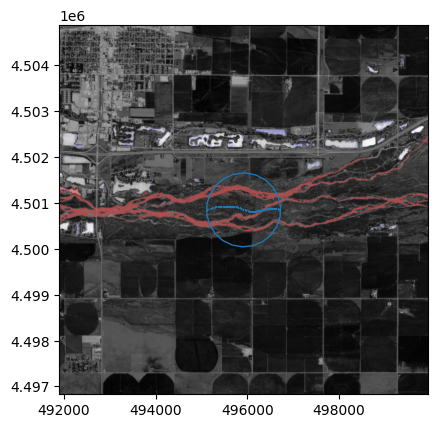

In [69]:
# tid = nonduplicate_id_hrefs.img_id[1]
# tindx = nonduplicate_id_hrefs.iindex[1]
tid = 'S2B_14TML_20240908_0_L2A'
tindx = 222016
# tid = 'S2A_14TMM_20241222_0_L2A'
show_plot(tid, tindx, squares, circles, vector_centerline)
print(tid, ', ', tindx)

In [ ]:
nonduplicate_id_hrefs.iindex 

In [38]:
nonduplicate_id_hrefs.loc[(nonduplicate_id_hrefs.img_id == tid) & (nonduplicate_id_hrefs.iindex == tindx)].reset_index()['b3_href'][0]

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/T/LM/2018/8/S2A_14TLM_20180809_1_L2A/B03.tif'

In [206]:
ndwi_v, rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_geom = GENERATE_MASKS(tid, tindx, circles, vector_centerline)
count_pixels(rmask, cloudmask, snowmask, ndmask, wwindow_transform, circle_geom)
# n_pixels, n_valid, n_river, n_cloud, n_snow, n_cloudriver, n_edge, n_edgeriver

(5085, 5085, 663, 0, 0, 0, 164, 0)

In [15]:
squares.set_index('iindex').loc[256673]

geometry    POLYGON ((-96.2944 41.20944, -96.2944 41.22671...
Name: 256673, dtype: geometry

In [394]:
HREFS[(tid, tindx)]

('https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/T/ML/2024/9/S2A_14TML_20240903_1_L2A/B03.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/T/ML/2024/9/S2A_14TML_20240903_1_L2A/B08.tif',
 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/14/T/ML/2024/9/S2A_14TML_20240903_1_L2A/SCL.tif')